# Fitting Logistic Growth Curves

---

## Background

In this tutorial we will cover how to fit growth curves on data from PhenoTypic. For growth curves you'll typically want to use metrics of size from `pht.measure.MeasureSize`: "Size_Area" or "Size_IntegratedIntensity". These can also be obtained from `pht.measure.MeasureArea` or `pht.measure.MeasureIntensity` respectively.

Size Metric Comparison:
| Metric                          | Pros                                         | Cons |
|:--------------------------------|:---------------------------------------------|:-----|
| "Shape_Area"                    | Simple to set up<br> Captures lateral growth | Misses Vertical Growth |
| "Intensity_IntegratedIntensity" | Captures lateral and vertical growth         | Requires color correction if there's significant color drift or lots of color variation between colonies |


Phenotypic uses the following form of the logistic formula:

### Logistic Kinetics Model

$N(t) = \frac{K } {1 + \frac{K - N0}{N0}  e^{-r t}}$

> $N_t$: population size at time t

> $N_0$: initial population size at time t

> $r$: growth rate

> $K$: Carrying capacity (maximum population size).

from which we can derive:

$µ_{max} = \frac{Kr}{4}$

> $µ_{max}$: maximum specific growth rate


To solver for the parameters, we use the following loss function with the scipy linear least squares solver

### Loss Function

$J(K,N_0,r) = \frac{1}{n}\sum_{i=1}^{n}\frac{1}{2}(f_{K,N0,r}(t^{(i)}) - N_t^{(i)})^2)
+ \lambda(\frac{dN}{dt}^2 + N_0^2)
+ \alpha \frac{\lvert K-\max({N_t})\rvert}{N_t}$

> $\lambda$: regularization term for growth rate and initial population size

> $\alpha$: penalty term for deviations in the carrying capacity relative to the largest measurement

## Overview
The data in this tutorial comes from the {doc} `QuickStart` tutorial

In this tutorial we use the following:
- `pht.analysis.LogGrowthModel`
- `pht.analysis.TukeysOutlierRemover`
- `pht.analysis.EdgeCorrector`

In [ ]:
import phenotypic as pht

meas = pht.data.load_quickstart_meas()
meas.head()

## Adding in metadata post-analysis for downstream processing

The original naming rule for this data was
`{Time}_{PlateSet}{Media}_{Replicate}`

Based on this naming rule, let's add the remaining metadata. These methods are all from `pandas.DataFrame`.

Note: This was the original naming rule, but it leads to some awkward splitting. It's usually better to separate independent variables with underscores and related variables with dashes.

In [2]:

# We split the ImageName using string and then unpack that into three new columns in the dataframe
meas[["Metadata_Time", "Metadata_SetMedia", "Metadata_Replicate"]] = \
    meas["Metadata_ImageName"].str.split("_", expand=True)

# Lets now split the {PlateSet}{Media} into different columns too
meas[["Metadata_PlateSet", "Metadata_Media"]] = meas["Metadata_SetMedia"].str.split("", expand=True)[[1, 2]]

# Time is a number, but because we split it from its name we need to convert it to the proper datatype
meas["Metadata_Time"] = meas["Metadata_Time"].astype(int)
meas["Metadata_PlateSet"] = meas["Metadata_PlateSet"].astype(int)

# Lets see our newest changes
meas[["Metadata_ImageName", "Metadata_Time", "Metadata_PlateSet", "Metadata_Media", "Metadata_Replicate"]].head()

,Metadata_ImageName,Metadata_Time,Metadata_PlateSet,Metadata_Media,Metadata_Replicate
0,2_1S_5,2,1,S,5
1,2_1S_5,2,1,S,5
2,2_1S_5,2,1,S,5
3,2_1S_5,2,1,S,5
4,2_1S_5,2,1,S,5


## Adding in metadata like strain name

While you can add the metadata per-image, its necessary to add it in post-extraction for things like colony strain names. To add in metadata like the strain name for each column to your data, we'll use table joining.


In [3]:

# Lets generate a synthetic table of strain names
import pandas as pd

# It's important to use the same names as the measurement dataframe
synth_names = pd.DataFrame(data={
    "Metadata_PlateSet"  : 1,
    "Grid_SectionNum"    : range(96),
    "Metadata_StrainName": [f"SYNTH-{idx:02d}" for idx in range(96)],
})

synth_names

,Metadata_PlateSet,Grid_SectionNum,Metadata_StrainName
0,1,0,SYNTH-00
1,1,1,SYNTH-01
2,1,2,SYNTH-02
3,1,3,SYNTH-03
4,1,4,SYNTH-04
...,...,...,...
91,1,91,SYNTH-91
92,1,92,SYNTH-92
93,1,93,SYNTH-93
94,1,94,SYNTH-94


In [4]:
meas = meas.merge(synth_names, on=["Metadata_PlateSet", "Grid_SectionNum"], how="inner")
meas.head()

,Metadata_FileSuffix,Metadata_BitDepth,Metadata_ImageType,Metadata_ImageName,ObjectLabel,Bbox_CenterRR,Bbox_CenterCC,Bbox_MinRR,Bbox_MinCC,Bbox_MaxRR,...,ColorHSV_BrightnessStdDev,ColorHSV_BrightnessCoeffVar,ColorLab_ChromaEstimatedMean,ColorLab_ChromaEstimatedMedian,Metadata_Time,Metadata_SetMedia,Metadata_Replicate,Metadata_PlateSet,Metadata_Media,Metadata_StrainName
0,.jpg,8,GridImage,2_1S_5,1,143.066954,638.928742,116,616,171,...,0.020981,0.068122,2.324505,2.412023,2,1S,5,1,S,SYNTH-03
1,.jpg,8,GridImage,2_1S_5,2,150.888348,489.121803,122,464,182,...,0.049686,0.131528,2.861581,3.057672,2,1S,5,1,S,SYNTH-02
2,.jpg,8,GridImage,2_1S_5,3,152.518557,962.014356,122,934,185,...,0.046833,0.115846,3.028543,3.214427,2,1S,5,1,S,SYNTH-05
3,.jpg,8,GridImage,2_1S_5,4,152.439723,1610.904644,125,1589,182,...,0.045290,0.116357,4.114455,4.538226,2,1S,5,1,S,SYNTH-09
4,.jpg,8,GridImage,2_1S_5,5,156.673430,802.163285,129,779,185,...,0.043493,0.113999,2.941698,3.139710,2,1S,5,1,S,SYNTH-04


In [5]:

meas[["Metadata_PlateSet", "Grid_SectionNum", "Metadata_StrainName", "Shape_Area"]].head()

,Metadata_PlateSet,Grid_SectionNum,Metadata_StrainName,Shape_Area
0,1,3,SYNTH-03,2091.0
1,1,2,SYNTH-02,2463.0
2,1,5,SYNTH-05,2856.0
3,1,9,SYNTH-09,2024.0
4,1,4,SYNTH-04,2070.0


In [6]:

# Lets isolate the measurements we care about
meas = (meas[["Metadata_ImageName", "Grid_SectionNum", "Metadata_Media", "Metadata_PlateSet", "Metadata_Replicate",
              "Metadata_StrainName",
              "Metadata_Time",
              "Shape_Area"]]
        .sort_values(by=['Metadata_StrainName', "Metadata_Time"]))

meas["Metadata_Time"] = meas["Metadata_Time"].astype(int)  # Ensures that the time column is numeric
meas.head(10)


,Metadata_ImageName,Grid_SectionNum,Metadata_Media,Metadata_PlateSet,Metadata_Replicate,Metadata_StrainName,Metadata_Time,Shape_Area
8,2_1S_5,0,S,1,5,SYNTH-00,2,2295.0
89,2_1S_6,0,S,1,6,SYNTH-00,2,2420.0
171,2_1S_7,0,S,1,7,SYNTH-00,2,2751.0
315,3_1S_5,0,S,1,5,SYNTH-00,3,2676.0
401,3_1S_6,0,S,1,6,SYNTH-00,3,2877.0
485,3_1S_7,0,S,1,7,SYNTH-00,3,3206.0
568,3_1S_8,0,S,1,8,SYNTH-00,3,2840.0
651,4_1S_5,0,S,1,5,SYNTH-00,4,2948.0
740,4_1S_6,0,S,1,6,SYNTH-00,4,3413.0
826,4_1S_7,0,S,1,7,SYNTH-00,4,3535.0


## Filtering and correction

In automated image processing, depending on the scene, objects can be:
- oversegmented (some of the background is detected along with the object)
- undersegmented (some of the object is not detected with the object)
- noise that was detected as an object

Other factors that may mess with our growth curves include stochastic biological noise or experimental error as well. To refine the data to reflect the true growth kinetics better, we can apply tukey's outlier and our edge correction method on the dataset.

(<Figure size 1000x1200 with 1 Axes>,
 <Axes: xlabel='Shape_Area', ylabel='Group'>)

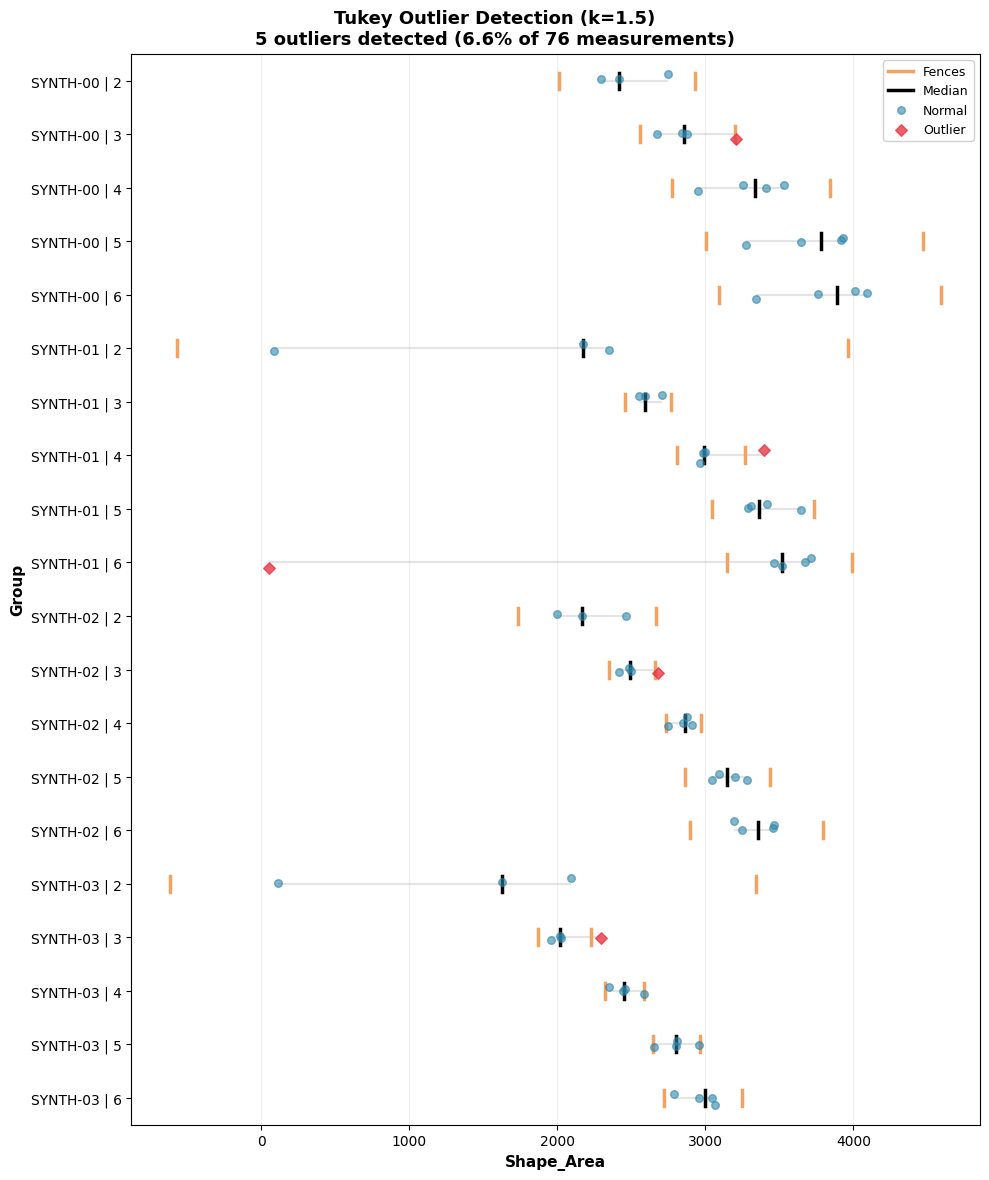

In [7]:
from phenotypic.analysis import TukeyOutlierRemover

tukey_outlier_analysis = TukeyOutlierRemover(
        on="Shape_Area",
        groupby=["Metadata_StrainName", "Metadata_Time"]
)

tukey_results = tukey_outlier_analysis.analyze(meas)

tukey_outlier_analysis.show(collapsed=True)


> Since there's a large amount of groups and they can't all be displayed, only the first 20 are displayed, but this can be changed.

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Edge Correction (Top N=3, p=0.05)'}, xlabel='Shape_Area'>)

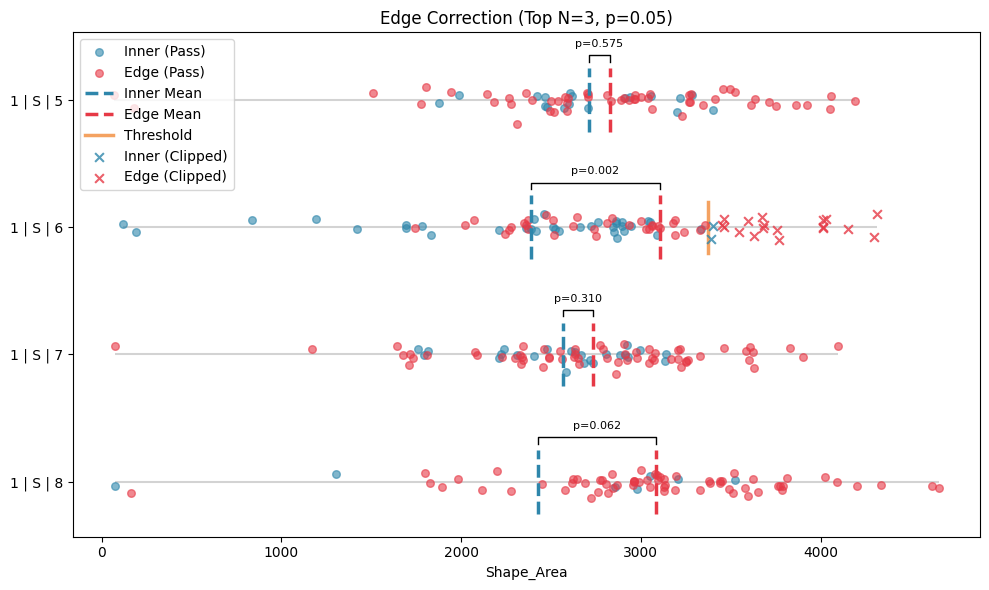

In [8]:
from phenotypic.analysis import EdgeCorrector

edge_correcter = EdgeCorrector(
        on="Shape_Area",
        groupby=["Metadata_PlateSet", "Metadata_Media", "Metadata_Replicate"],
        time_label="Metadata_Time",
)

edge_corrected = edge_correcter.analyze(tukey_results)
edge_correcter.show(collapsed=True)


## Fit model

**New parameters:**
> `lam`: The regularization factor for specific growth rate
> `alpha`: The penalty term for the relative deviation from the max of the carrying capacity

In [9]:
log_model = pht.analysis.LogGrowthModel(on='Shape_Area', groupby=['Metadata_StrainName'],
                                        agg_func='mean',
                                        time_label='Metadata_Time',
                                        lam=0.5,
                                        alpha=2.0,
                                        n_jobs=-1)
model_fit = log_model.analyze(meas)
model_fit.head()


,Metadata_StrainName,LogGrowthModel_r,LogGrowthModel_K,LogGrowthModel_N0,LogGrowthModel_µmax,LogGrowthModel_Kmax,LogGrowthModel_NumSamples,LogGrowthModel_OptimizerLoss,LogGrowthModel_OptimizerStatus,LogGrowthModel_MAE,LogGrowthModel_MSE,LogGrowthModel_RMSE
0,SYNTH-00,0.882962,3803.000000,731.050357,839.475765,3803.00,5,359014.371364,2,111.664757,19690.330182,140.322237
1,SYNTH-01,1.062408,3262.010706,363.235125,866.396198,3414.25,5,348964.083825,2,212.846392,51327.417300,226.555550
2,SYNTH-02,0.861747,3321.531212,663.466829,715.579876,3341.25,5,285067.340599,2,100.423547,18802.656973,137.122781
3,SYNTH-03,0.903318,2963.500000,347.147868,669.245998,2963.50,5,155206.330925,2,63.041344,5242.347575,72.404058
4,SYNTH-04,0.885146,3032.000000,593.850922,670.940923,3032.00,5,236673.126701,2,93.985535,14387.186777,119.946600


**Parameters:**
- `on`: What column to measure on
- `groupby`: What columns to form groups on. See also: `pandas.DataFrame.groupby()`
- `agg_func`: How to aggregate replicate time points. Default is "mean". For other options see: `pandas.DataFrame.agg()`
- `time_label`: What column is to use for the time measurement. This should be added by the user either as metadata or externally.

## Display results

(<Figure size 600x400 with 1 Axes>, <Axes: title={'center': 'mean±SE'}>)

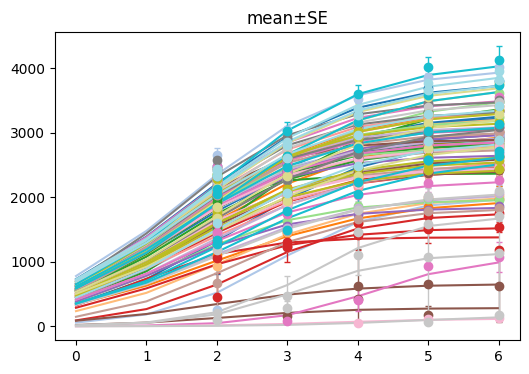

In [10]:
log_model.show()


(<Figure size 600x400 with 1 Axes>, <Axes: title={'center': 'mean±SE'}>)

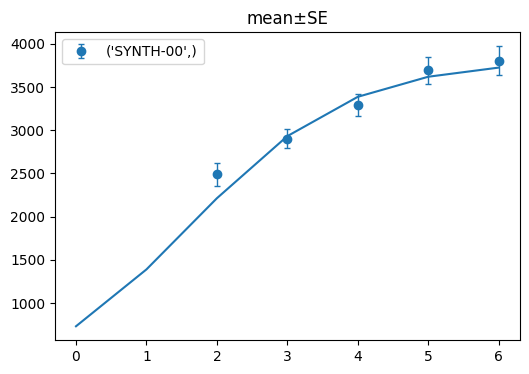

In [11]:
log_model.show(criteria={'Metadata_StrainName': ['SYNTH-00']})


If we want to display only one of the strains, we can use the criteria like above. You can specify which column you want to filter by as a key and provide the